## Linear Regression for Spine Moments

The primary goal with this notebook is to re-create the Linear Regression model using the AWS SageMaker platform.

## Imports

In [22]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)

from sklearn import svm, preprocessing, metrics, linear_model

import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.amazon import amazon_estimator

## Download and parse dataset

In [4]:
def download_dataset(s3_uri):
    bucket, path = sagemaker.s3.parse_s3_url(s3_uri)
    local_path = Path(path)
    if not local_path.exists():
        sagemaker.s3.S3Downloader.download(s3_uri, local_path.parent)
    return local_path

def load_dataset(file_name):
    df = pd.read_csv(file_name)
    df = df.dropna()
    #df = df.set_index(['Trial_Name', 'Trial_Index']);
    #df.sort_index(
    #    level=['Trial_Name','Trial_Index'], 
    #    ascending=[True, True], inplace=True)
    return df

local_dataset = download_dataset("s3://cpac/ORIG/S1_lumbar_results.csv")
print(f"Local dataset: {local_dataset} [{local_dataset.stat().st_size} bytes]")
df = load_dataset(local_dataset)

Local dataset: ORIG/S1_lumbar_results.csv [236614139 bytes]


## Understand the dataset format

In [5]:
print("Number of samples:" ,df.shape[0])
print("Number of trials:", len(df["Trial_Name"].unique()))

features = df.loc[:, "GRF_LeftFoot":].columns.to_list()
print("Number of features:", len(features))
print("Features:", ", ".join(features))

targets = [
           "Pelvis_Moment_X", 
           "Pelvis_Moment_Y", 
           "Pelvis_Moment_Z", 
           "single_equiv_force", 
           "poly_force"]
print("Number of targets:", len(targets))
print("Targets:", ", ".join(targets))

Number of samples: 257887
Number of trials: 309
Number of features: 30
Features: GRF_LeftFoot, GRF_RightFoot, LEFT_COP_Y, LEFT_COP_X, RIGHT_COP_Y, RIGHT_COP_X, LEFT_FOOT_ANGLE_X, LEFT_FOOT_ANGLE_Y, LEFT_FOOT_ANGLE_Z, RIGHT_FOOT_ANGLE_X, RIGHT_FOOT_ANGLE_Y, RIGHT_FOOT_ANGLE_Z, LEFT_SHANK_ANGLE_X, LEFT_SHANK_ANGLE_Y, LEFT_SHANK_ANGLE_Z, RIGHT_SHANK_ANGLE_X, RIGHT_SHANK_ANGLE_Y, RIGHT_SHANK_ANGLE_Z, LEFT_THIGH_ANGLE_X, LEFT_THIGH_ANGLE_Y, LEFT_THIGH_ANGLE_Z, RIGHT_THIGH_ANGLE_X, RIGHT_THIGH_ANGLE_Y, RIGHT_THIGH_ANGLE_Z, PELVIS_ANGLE_X, PELVIS_ANGLE_Y, PELVIS_ANGLE_Z, TRUNK_ANGLE_X, TRUNK_ANGLE_Y, TRUNK_ANGLE_Z
Number of targets: 5
Targets: Pelvis_Moment_X, Pelvis_Moment_Y, Pelvis_Moment_Z, single_equiv_force, poly_force


## Test / train split

We are also selecting the target variable and the (sub)set of features.

In [6]:
def train_test_split(df, features, target, test_trial, n_train=-1):
    
    # test/train selection
    test_select = (df["Trial_Name"] == test_trial)
    df_train = df[~test_select]
    df_test = df[test_select]

    # downselect - too much data for SVM
    if n_train > 0:
        df_train = df_train.sample(n = n_train)

    # normalization
    norm = preprocessing.StandardScaler()
    X_train = norm.fit_transform(df_train[features])
    X_test = norm.transform(df_test[features])

    # select target variable
    return (
        X_train, X_test, 
        df_train[target], df_test[target])
    
TEST_TRIAL = "ESM_raisedstoop_5kg_01"
TARGET = targets[0]
FEATURES = features[:]

X_train, X_test, y_train, y_test = train_test_split(
    df, FEATURES, TARGET, TEST_TRIAL, 20_000)

print(
    "Shapes X_train: %s, X_test: %s, y_train: %s, y_test: %s" %
    (X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Shapes X_train: (20000, 30), X_test: (1302, 30), y_train: (20000,), y_test: (1302,)


## Convert and upload the data for training

We are using the recordIO-wrapped protobuf format.

In [23]:
def upload_tensor(s3_uri, X, y):
    bucket, path = sagemaker.s3.parse_s3_url(s3_uri)
    local_path = Path(path)
    local_path.parent.mkdir(parents=True, exist_ok=True)
    with local_path.open("wb") as f:
        smac.write_numpy_to_dense_tensor(f, np.array(X).astype('float32'), np.array(y).astype('float32'))

    sagemaker.s3.S3Uploader.upload(str(local_path), s3_uri)
    return local_path

s3_train_data = "s3://cpac/SM/S1_lumbar_results/train.dat"
upload_tensor(s3_train_data, X_train, y_train)
print('Uploaded training data to: {}'.format(s3_train_data))

s3_test_data = "s3://cpac/SM/S1_lumbar_results/test.dat"
upload_tensor(s3_test_data, X_test, y_test)
print('Uploaded test data to: {}'.format(s3_test_data))

Uploaded training data to: s3://cpac/SM/S1_lumbar_results/train.dat
Uploaded test data to: s3://cpac/SM/S1_lumbar_results/test.dat


## Training

In [ ]:
sess = sagemaker.Session()
region = sess.boto_session.region_name
role = sagemaker.get_execution_role()

container = amazon_estimator.get_image_uri(region, "linear-learner")
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type="ml.c4.xlarge",
                                       output_path="s3://cpac/SM/S1_lumbar_results/output",
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=X_train.shape[1],
                           mini_batch_size=100,
                           predictor_type='regressor',
                           epochs=10,
                           num_models=32,
                           loss='squared_loss')

linear.fit({'train': s3_train_data, 'test': s3_test_data})

2020-01-14 16:21:46 Starting - Starting the training job...
2020-01-14 16:21:48 Starting - Launching requested ML instances.........
2020-01-14 16:23:23 Starting - Preparing the instances for training...
2020-01-14 16:24:13 Downloading - Downloading input data
2020-01-14 16:24:13 Training - Downloading the training image...
2020-01-14 16:24:48 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[01/14/2020 16:24:51 INFO 140050893207360] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'a

[2020-01-14 16:25:03.349] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 3818, "num_examples": 200, "num_bytes": 3360000}
#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.09072959250211715, "sum": 0.09072959250211715, "min": 0.09072959250211715}}, "EndTime": 1579019103.349825, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1579019103.349745}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.09039671816825867, "sum": 0.09039671816825867, "min": 0.09039671816825867}}, "EndTime": 1579019103.349895, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1579019103.349878}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.09099188144207, "sum": 0.09099188144207, "min": 0.09099188144207}}, "EndTime": 1579019103.349953, "Dimensions": {"mo

[2020-01-14 16:25:17.938] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 3813, "num_examples": 200, "num_bytes": 3360000}
#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.08789811154603958, "sum": 0.08789811154603958, "min": 0.08789811154603958}}, "EndTime": 1579019117.938364, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1579019117.93828}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.0894640507221222, "sum": 0.0894640507221222, "min": 0.0894640507221222}}, "EndTime": 1579019117.938452, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1579019117.938431}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.08785067876577378, "sum": 0.08785067876577378, "min": 0.08785067876577378}}, "EndTime": 1579019117.93852, "Dimensions":

[2020-01-14 16:25:25.551] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 3738, "num_examples": 200, "num_bytes": 3360000}
#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.0873097100019455, "sum": 0.0873097100019455, "min": 0.0873097100019455}}, "EndTime": 1579019125.551682, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1579019125.551602}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.08933538707494736, "sum": 0.08933538707494736, "min": 0.08933538707494736}}, "EndTime": 1579019125.551757, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1579019125.551739}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.08727253754138947, "sum": 0.08727253754138947, "min": 0.08727253754138947}}, "EndTime": 1579019125.551817, "Dimensions


2020-01-14 16:25:41 Uploading - Uploading generated training model
2020-01-14 16:25:41 Completed - Training job completed
Training seconds: 99
Billable seconds: 99


## Prediction

In [ ]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium')

In [32]:
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = sagemaker.predictor.csv_serializer
linear_predictor.deserializer = sagemaker.predictor.json_deserializer

result = linear_predictor.predict(X_test)

----------------------------------------------------------------------------------------------------------------------------------------------------!

## Delete the Endpoint
If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [33]:
sess.delete_endpoint(linear_predictor.endpoint)

## Show results

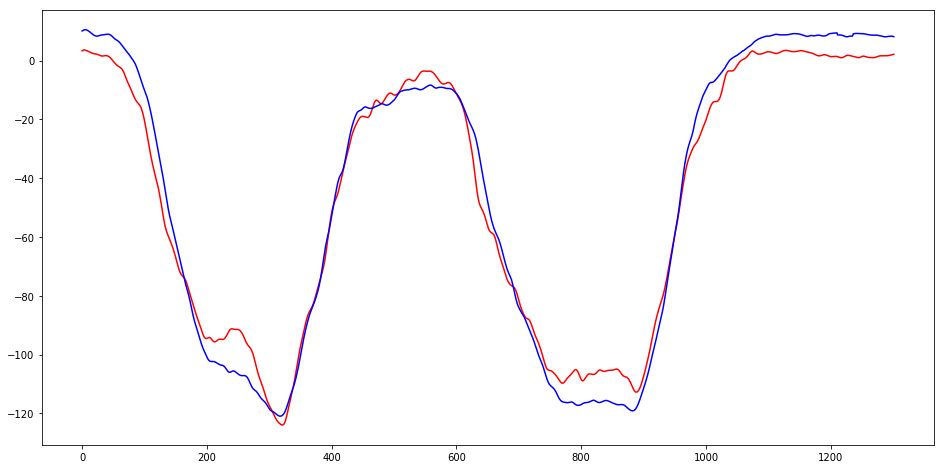

In [44]:
y_pred = np.array([r['score'] for r in result['predictions']])
plt.plot(y_test.values, 'r')
plt.plot(y_pred, 'b')